<a href="https://colab.research.google.com/github/Vivian0105/Bioinformatics/blob/main/scRNAseq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# !pip install scanpy
# !pip install cupy-cuda11x
# !pip install leidenalg
# !pip install igraph
# !pip install gseapy
# !pip install statannot
#!pip install seaborn==0.11.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.10.4 requires seaborn>=0.13, but you have seaborn 0.11.2 which is incompatible.


In [1]:
import warnings
warnings.simplefilter("ignore")
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import seaborn as sns
import os
import glob
import leidenalg
import gseapy as gp
from statannot import add_stat_annotation
from gseapy import barplot, dotplot
dir='drive/MyDrive/scRNAseq/'

In [ ]:
samples=glob.glob(dir+'*.h5')

In [ ]:
samples[:3]

['drive/MyDrive/scRNAseq/GSM4115880_SC68raw_feature_bc_matrix.h5',
 'drive/MyDrive/scRNAseq/GSM4115882_SC70raw_feature_bc_matrix.h5',
 'drive/MyDrive/scRNAseq/GSM4115881_SC69raw_feature_bc_matrix.h5']

In [ ]:
meta=pd.read_csv(dir+'SraRunTable.csv')
meta.head(2)

,Run,Assay Type,AssemblyName,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,chemistry,...,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue
0,SRR10254548,RNA-Seq,GCF_000001405.29,98,20294765414,PRJNA576702,SAMN13002514,8453401374,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:19:00Z,1,GSM4115868,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"
1,SRR10254549,RNA-Seq,GCF_000001405.29,98,26778655722,PRJNA576702,SAMN13002513,10356538606,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:18:00Z,1,GSM4115869,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"


In [ ]:
# Read h5 files of each sample and concatenate the samples together
adatas = {}
for sample in samples:
    sample_name=sample.split('/')[-1]
    sample_name=sample_name[:10]
    sample_adata = sc.read_10x_h5(sample)
    sample_adata.var_names_make_unique()
    sample_adata.obs['tissue']='skin'
    sample_adata.obs['sample_name']=sample_name
    sample_adata.obs['condition']=meta[meta['Sample Name']==sample_name]['condition'].item()
    adatas[sample_name] = sample_adata
adata = anndata.concat(adatas)
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16220160 × 33538
    obs: 'tissue', 'sample_name', 'condition'

In [ ]:
adata.obs[['sample_name','condition']].drop_duplicates().condition.value_counts()

,count
condition,
SSC,12
CONTROL,10


In [ ]:
adata.write(dir+'GSE138669_RAW.h5ad')

In [ ]:
# Now we have concatenated raw data of 22 patients with 16220160 cells and 33538 measured genes.

In [ ]:
# Data Preprocessing

In [ ]:
adata=anndata.read_h5ad(dir+'GSE138669_RAW.h5ad')

In [ ]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
# filtered cells with less than 100 genes expressed.
# filtered genes that are detected in less than 3 cells.
print('Before filtering, there are %i cells with %i measured genes'%(adata.n_obs, adata.n_vars))
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print('After filtering, there are %i cells left with %i genes'%(adata.n_obs, adata.n_vars))

Before filtering, there are 16220160 cells with 33538 measured genes
After filtering, there are 108726 cells left with 25208 genes


In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

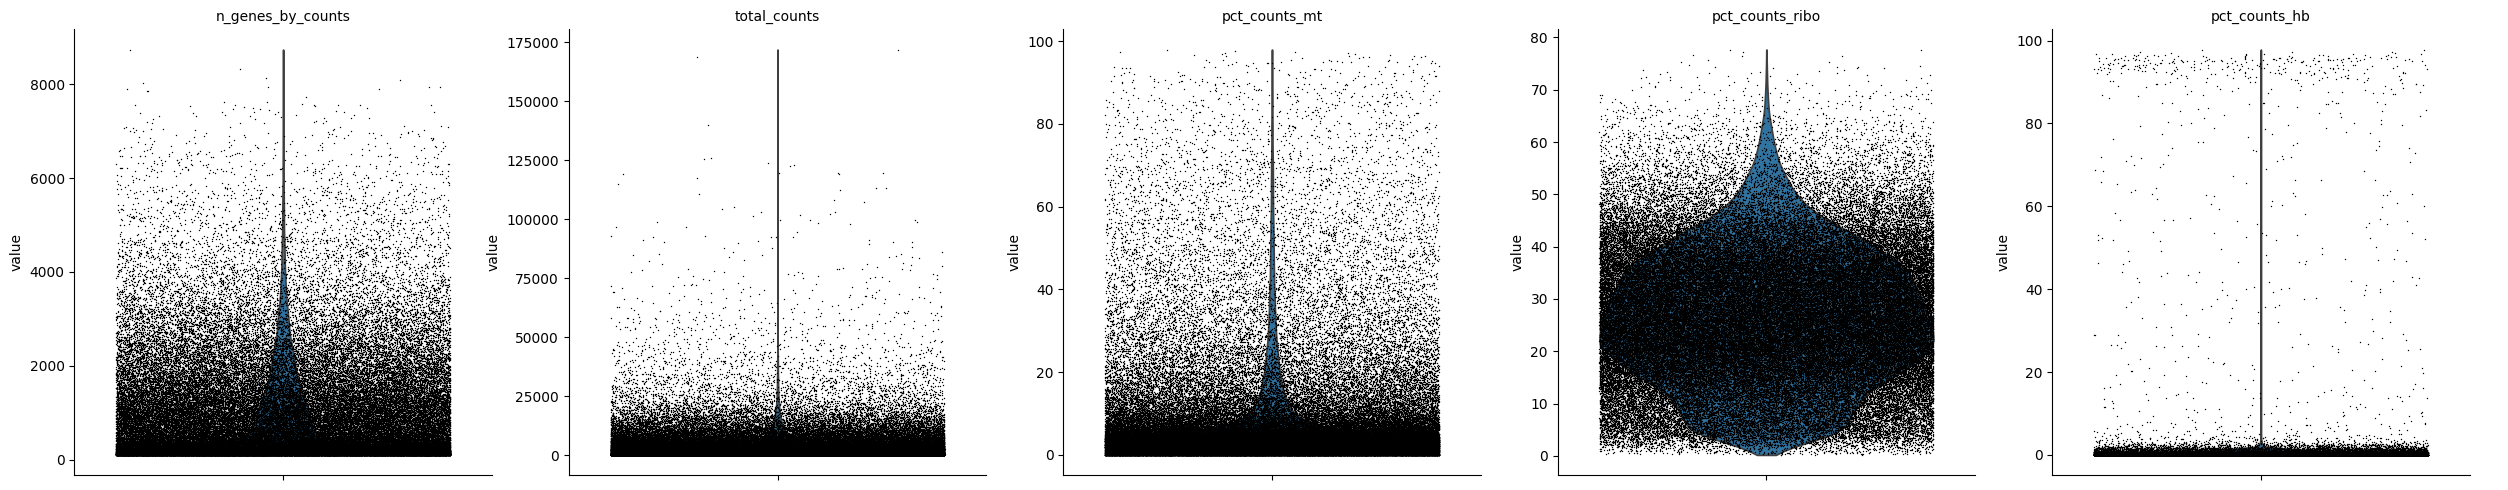

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts","pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True
)

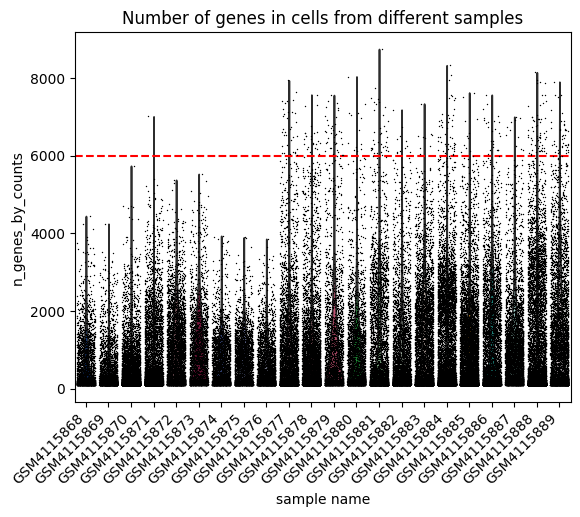

In [ ]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ['n_genes_by_counts'],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Number of genes in cells from different samples")
ax.axhline(y=6000, color='r', linestyle='--')
plt.show()

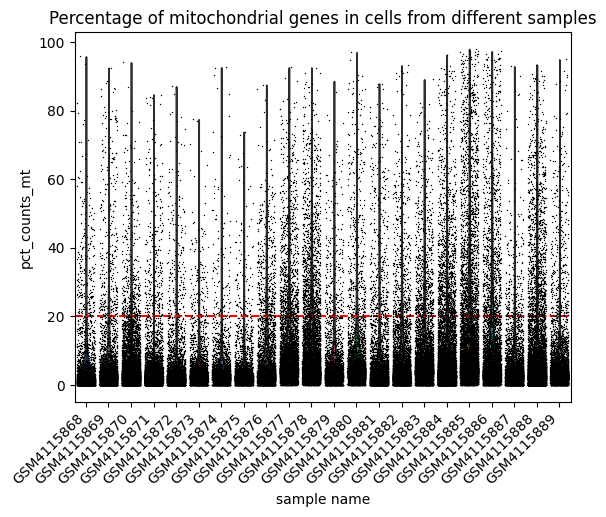

In [ ]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Percentage of mitochondrial genes in cells from different samples")
ax.axhline(y=20, color='r', linestyle='--')
plt.show()

In [ ]:
# Filter out cells with more than 6000 genes and cells with more than 20% mitochondrial genes

In [ ]:
print('Before filtering, there are %i cells'%adata.n_obs)
adata=adata[adata.obs['n_genes_by_counts']<6000]
adata=adata[adata.obs['pct_counts_mt']<20]
print('After filtering, there are %i cells left.'%adata.n_obs)

Before filtering, there are 108726 cells
After filtering, there are 96808 cells left.


In [ ]:
# doublet detection by method Scrublet (optional)
# sc.pp.scrublet(adata, batch_key="sample_name")

In [ ]:
adata.var.head()

,mt,ribo,hb,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AL627309.1,False,False,False,118,118,0.001104,0.001103,99.891470,120.0,4.795791
AL627309.3,False,False,False,10,10,0.000092,0.000092,99.990803,10.0,2.397895
AL732372.1,False,False,False,5,5,0.000046,0.000046,99.995401,5.0,1.791759
AL669831.5,False,False,False,1822,1822,0.019075,0.018896,98.324228,2074.0,7.637716
FAM87B,False,False,False,123,123,0.001306,0.001305,99.886872,142.0,4.962845


In [ ]:
# Remove mitochondrial, ribosomal and hemoglobin genes.
adata=adata[:, ~adata.var['mt']==True]
adata=adata[:, adata.var['ribo']==False]
adata=adata[:, adata.var['hb']==False]
print("%i genes left after removing mitochondrial, ribosomal and hemoglobin genes."%adata.n_vars)

25080 genes left after removing mitochondrial, ribosomal and hemoglobin genes.


In [ ]:
adata.write(dir+"GSE138669_after_QC.h5ad")

In [ ]:
# Normalization and Dimension Reduction

In [ ]:
adata=anndata.read_h5ad(dir+"GSE138669_after_QC.h5ad")

In [ ]:
# Saving raw count
adata.layers["raw"] = adata.X.copy()

In [ ]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
adata_sub = adata[:, adata.var.highly_variable]

In [ ]:
adata_sub

View of AnnData object with n_obs × n_vars = 96808 × 3636
    obs: 'tissue', 'sample_name', 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw'

In [ ]:
# principal component analysis which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_sub, svd_solver="arpack")

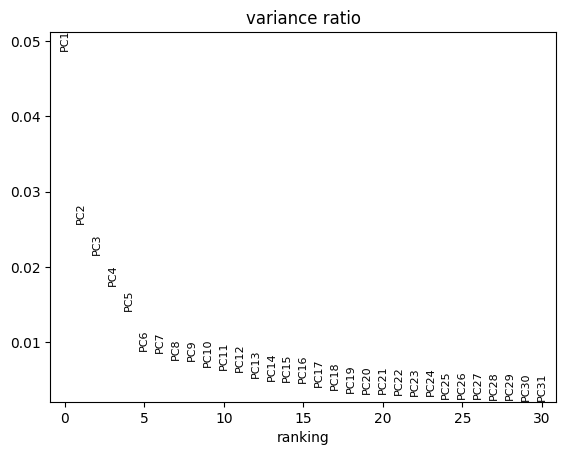

In [ ]:
sc.pl.pca_variance_ratio(adata_sub, log=False)

In [ ]:
sc.pp.neighbors(adata_sub, n_neighbors=20, n_pcs=30)

In [ ]:
sc.tl.umap(adata_sub)

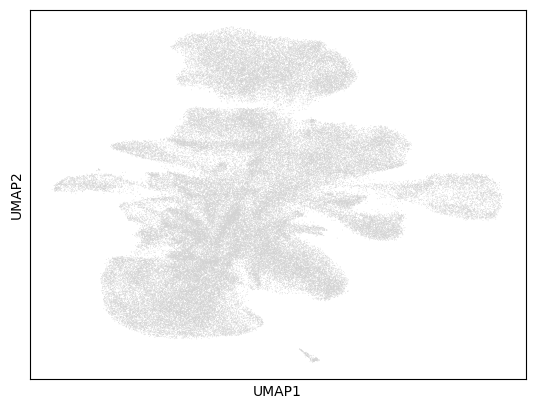

In [ ]:
sc.pl.umap(adata_sub)

In [ ]:
for res in [0.1, 0.5, 1.0]:
    sc.tl.leiden(
        adata_sub, key_added=f"leiden_res_{res:2.1f}", resolution=res, flavor="igraph"
    )

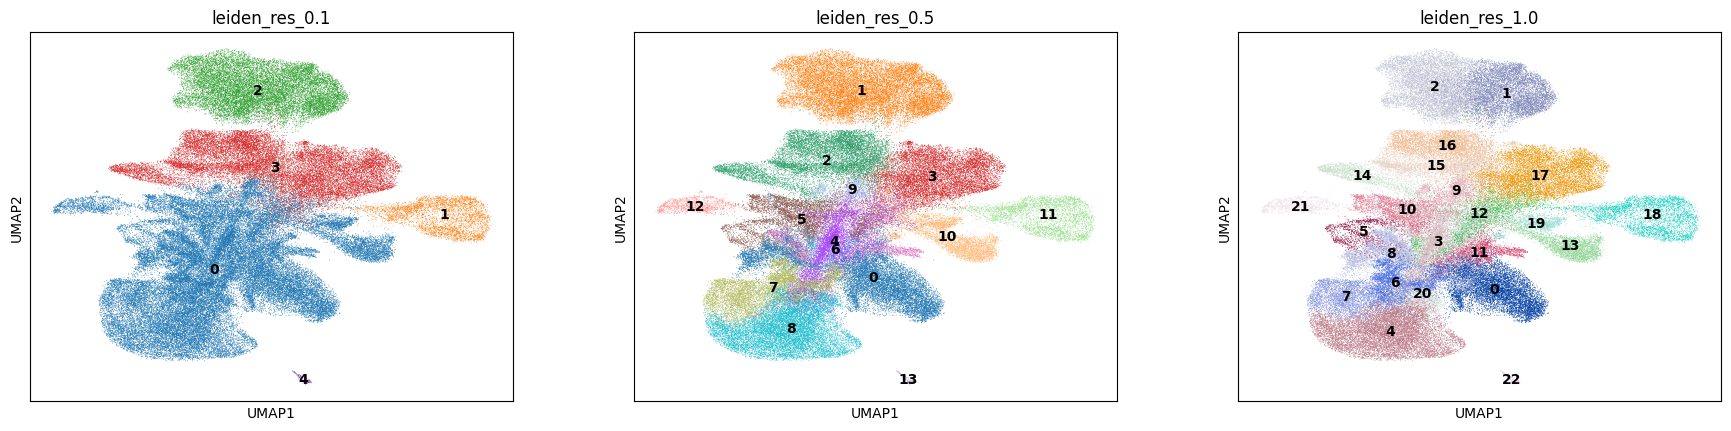

In [ ]:
sc.pl.umap(
    adata_sub,
    color=["leiden_res_0.1", "leiden_res_0.5", "leiden_res_1.0"],
    legend_loc="on data",
)

In [ ]:
adata.obs=adata_sub.obs
adata.uns=adata_sub.uns
adata.obsm=adata_sub.obsm
adata.obsp=adata_sub.obsp

In [ ]:
adata.write(dir+'GSE138669_after_leiden.h5ad')

In [ ]:
# Further analysis

In [5]:
adata=anndata.read_h5ad(dir+'GSE138669_after_leiden.h5ad')

In [6]:
plt.rcParams['figure.figsize'] = [4, 4]

In [ ]:
# plots to show the distribution of SSc and control samples in each cluster

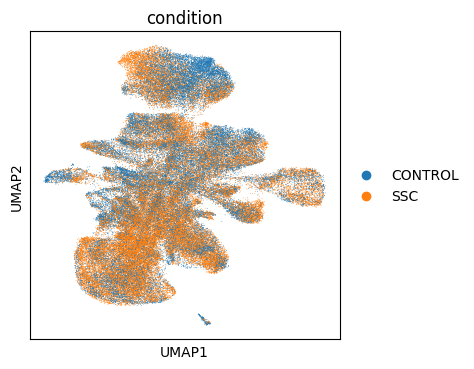

In [ ]:
sc.pl.umap(adata,color='condition')

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='condition')

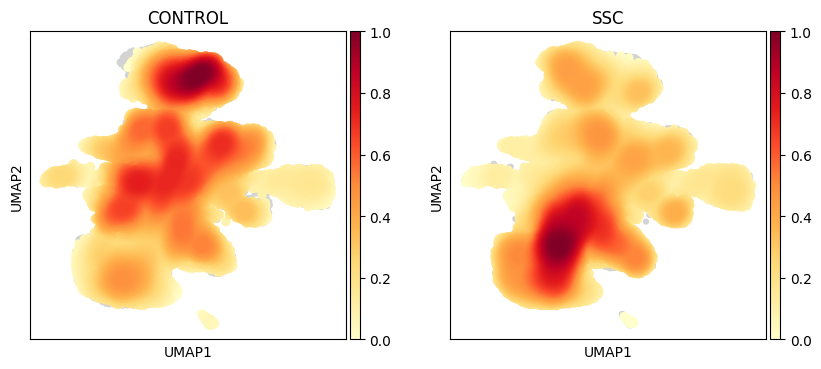

In [ ]:
sc.pl.embedding_density(
    adata, basis='umap', key='umap_density_condition')

In [ ]:
# Conposition of cells from different condition in each cluster

In [ ]:
def stackbar_leiden(leiden='leiden_res_0.1',figsize=(7,5)):
  df=adata.obs[['condition',leiden]].groupby(['condition',leiden]).size()
  df=df.reset_index(level=['condition'])
  df.rename({0: 'CellNumber'}, axis=1, inplace=True)
  df=df.pivot_table(values="CellNumber", index=leiden, columns="condition")
  df['Number_of_Patients']=df['CONTROL']+df['SSC']
  df['CONTROL']=df['CONTROL']/df['Number_of_Patients']
  df['SSC']=df['SSC']/df['Number_of_Patients']
  ax=df[['CONTROL','SSC']].plot(kind='bar', stacked=True, figsize=figsize)
  ax.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
  plt.show()

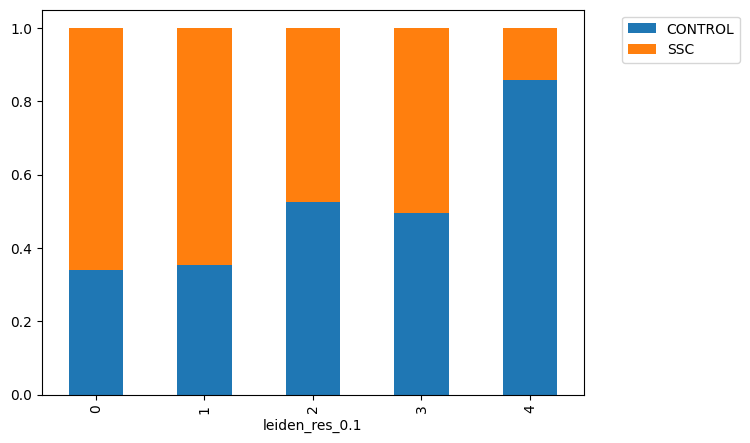

In [ ]:
stackbar_leiden('leiden_res_0.1')

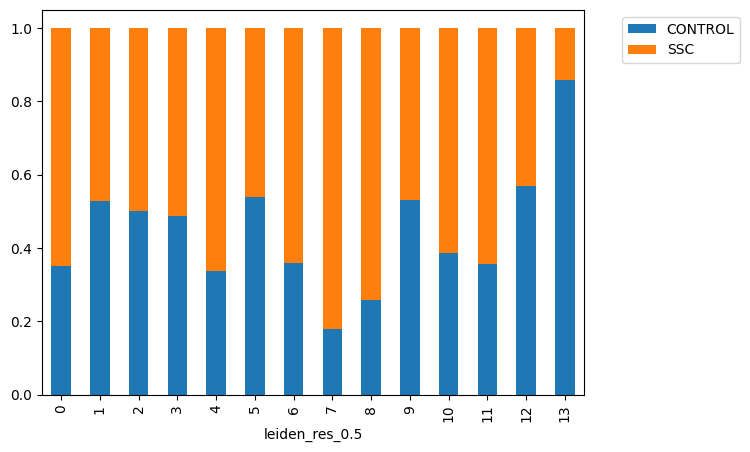

In [ ]:
stackbar_leiden('leiden_res_0.5')

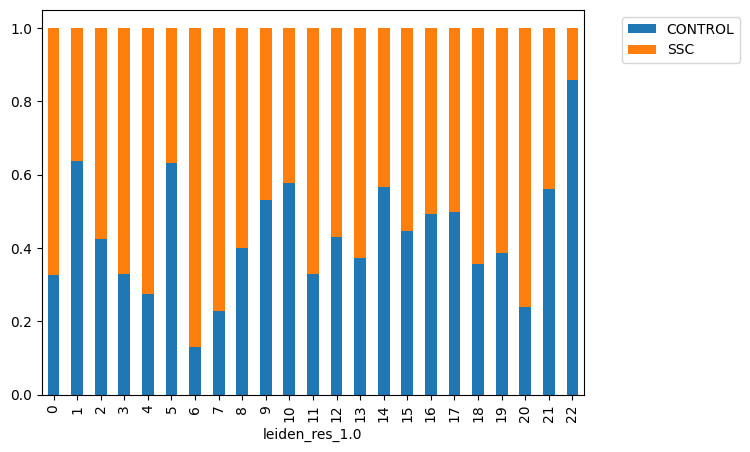

In [ ]:
stackbar_leiden('leiden_res_1.0')

In [6]:
# Marker genes for annotation

In [7]:
marker_genes = {
    "Immune": ["PTPRC","CD79A","JCHAIN",'CD3D','CD8A','NKG7','FCGR3A','CD14','CD4'],
    "Epithelial": ['EPCAM','MUC1','OCLN','KRT14','AQP1'],
    'Endothelia':['CD34', 'PECAM1','SELE'],
     'Fibroblast':['COL1A1','LUM','APOD','MMP2','FAP','PDGFRA','VIM']}

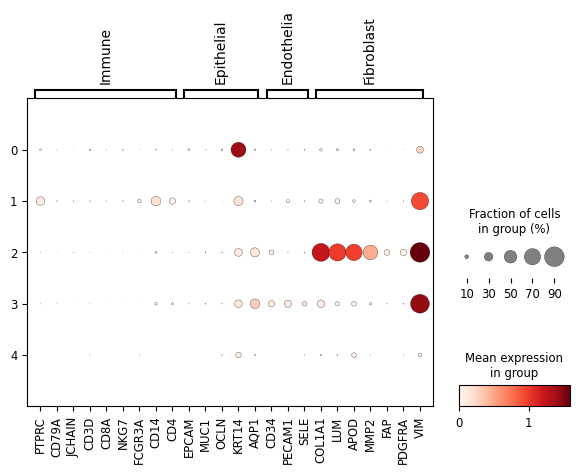

In [9]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.1",figsize=(7,4))

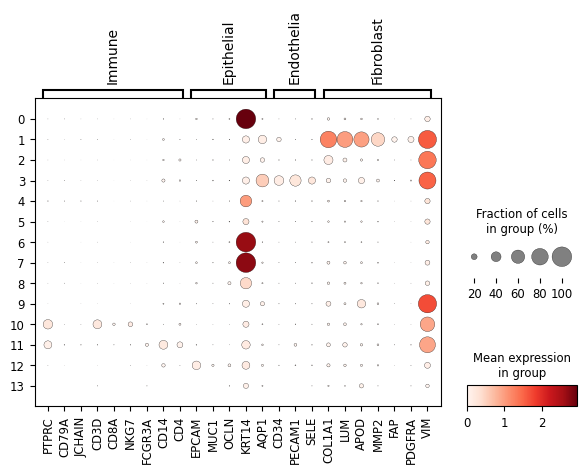

In [8]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.5",figsize=(7,4))

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.5", method="wilcoxon")

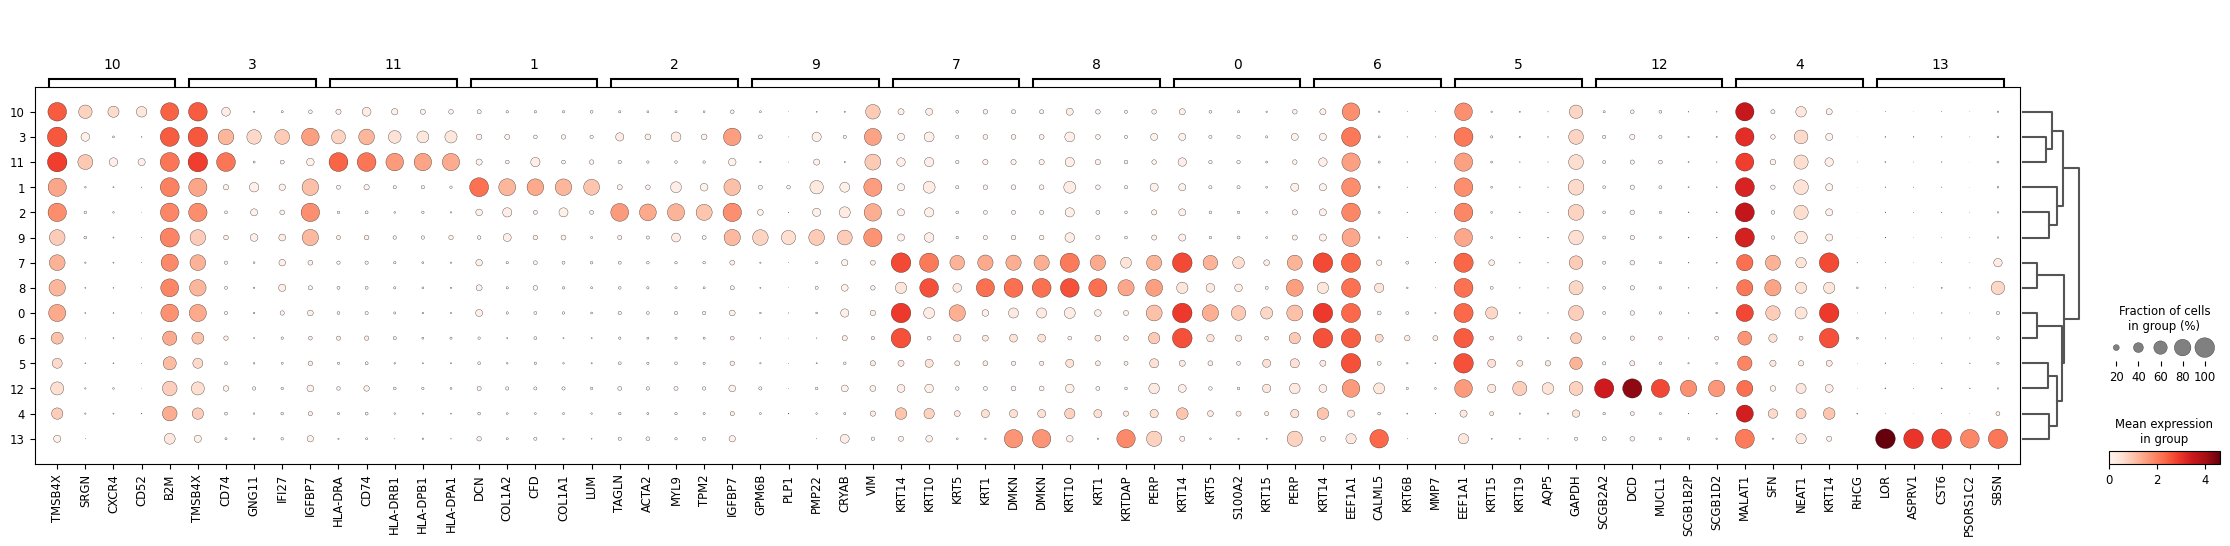

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.5",  n_genes=5
)

DEGs and Pathway analysis

In [10]:
# Leiden_res_0.1 cluster2 is Fibroblasts. Find the DEGs bwteen SSc and control in Fibroblasts and related pathways.

In [7]:
adata_fib=adata[adata.obs['leiden_res_0.1']=='2']
adata_fib.n_obs

15425

In [8]:
sc.tl.rank_genes_groups(adata_fib, groupby='condition',groups=['SSC'],reference='CONTROL', method="wilcoxon", pts=True,key_added='SSC_vs_CONTROL')

In [9]:
DEGs=sc.get.rank_genes_groups_df(adata_fib, group="SSC", key='SSC_vs_CONTROL')

In [22]:
DEGs.head(5)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
0,THY1,35.251072,1.563606,3.303723e-272,2.761912e-268,0.601287
1,SPARC,33.848019,1.181981,3.881178e-251,2.433499e-247,0.799480
2,COL1A1,33.319447,1.175269,2.018941e-243,1.012701e-239,0.856009
3,PRSS23,32.121059,2.509064,2.240683e-226,9.366053e-223,0.404462
4,COL6A3,31.805937,1.379290,5.358265e-222,1.679816e-218,0.591432


In [23]:
DEGs.tail(5)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
25075,MALAT1,-29.498228,-0.564261,3.033584e-191,6.916571e-188,0.962770
25076,MTRNR2L1,-29.659918,-2.682738,2.526560e-193,6.336611e-190,0.069121
25077,DCN,-31.824295,-0.694704,2.986152e-222,1.069895e-218,0.933616
25078,CFD,-40.543129,-1.316246,0.000000e+00,0.000000e+00,0.730906
25079,GSN,-45.169941,-1.524738,0.000000e+00,0.000000e+00,0.701752


In [26]:
DEGs_up=DEGs.loc[(DEGs['logfoldchanges']>1) & (DEGs['pvals_adj']<0.05),:]
DEGs_down=DEGs.loc[(DEGs['logfoldchanges']<-1) & (DEGs['pvals_adj']<0.05),:]
print('In fibroblast, there are %i genes expressed more in SSc and %i genes expressed less in SSc'%(DEGs_up.shape[0], DEGs_down.shape[0]))

In fibroblast, there are 240 genes expressed more in SSc and 42 genes expressed less in SSc


In [33]:
# Enrichment analysis with list of SSc up regulated genes

In [11]:
gene_sets=['GO_Biological_Process_2023','KEGG_2021_Human','Reactome_2022']

In [44]:
enr = gp.enrichr(gene_list=list(DEGs_up['names']),
                 gene_sets=gene_sets,
                 organism='human',
                 outdir=None)

In [52]:
enr.results.head(3)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2023,Negative Regulation Of Plasminogen Activation ...,5/6,1.418092e-09,0.000002,0,0,420.404255,8565.296876,SERPINE2;PLAU;SERPINE1;SERPINF2;THBS1
1,GO_Biological_Process_2023,Regulation Of Angiogenesis (GO:0045765),16/205,3.827225e-09,0.000003,0,0,7.396447,143.351480,SEMA5A;SPARC;CXCL8;STAT1;SPHK1;SERPINE1;KRT1;H...
2,GO_Biological_Process_2023,Regulation Of Plasminogen Activation (GO:0010755),6/16,2.031259e-08,0.000012,0,0,50.641026,896.955112,SERPINE2;PLAU;SERPINE1;SERPINF2;THBS1;RUNX1


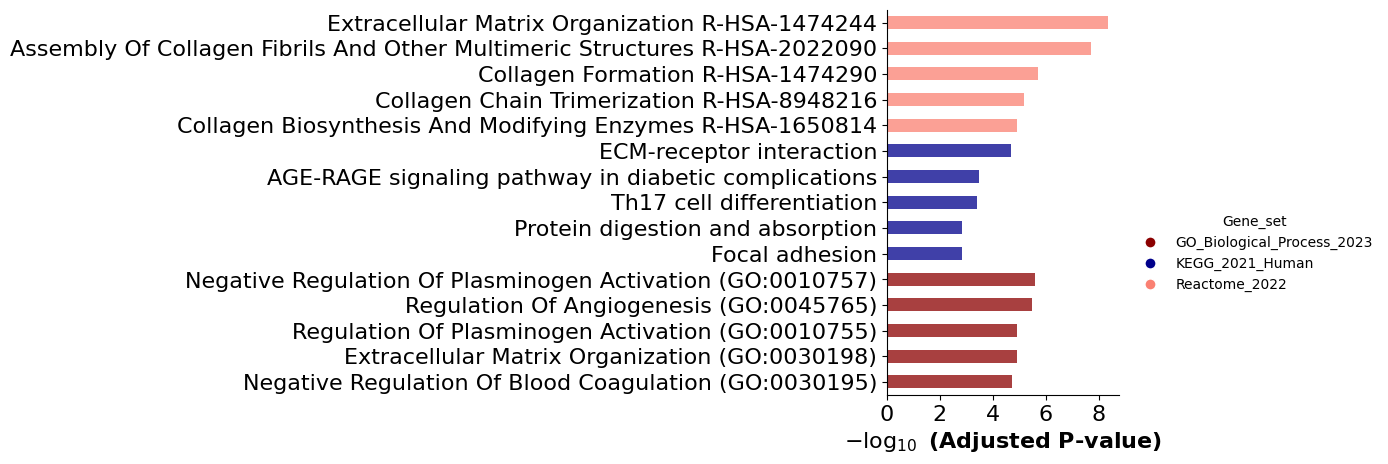

In [54]:
colors=['darkred','darkblue','salmon']
color_dic={}
for gene_set, color in zip(gene_sets,colors):
  color_dic[gene_set]=color
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set',
              size=6,
              top_term=5,
              figsize=(3,5),
              color = color_dic
             )

In [1]:
# run GSEA prerank

In [10]:
rank=DEGs[['names','scores']]
rank.index=rank['names']
rank.drop('names',axis=1,inplace=True)
rank.head()

,scores
names,
THY1,35.251072
SPARC,33.848019
COL1A1,33.319447
PRSS23,32.121059
COL6A3,31.805937


In [12]:
pre_res = gp.prerank(rnk=rank,
                     gene_sets=gene_sets,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=500,
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=False
                    )

2024-11-17 23:24:35,031 [WARNING] Duplicated values found in preranked stats: 32.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [16]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Reactome_2022__Fatty Acids R-HSA-211935,-0.838436,-1.98384,0.0,0.03142,0.024,1/12,0.56%,CYP4B1
1,prerank,Reactome_2022__Digestion R-HSA-8935690,-0.886449,-1.946856,0.0,0.03142,0.05,4/17,2.68%,PIR;AMY2B;PNLIPRP3;PMEL
2,prerank,GO_Biological_Process_2023__Receptor Guanylyl ...,-0.899325,-1.832786,0.0,0.187025,0.348,5/8,6.33%,NPR2;NPR1;NPPC;GUCY2D;NPPA
3,prerank,GO_Biological_Process_2023__Regulation Of Lymp...,-0.858834,-1.798409,0.0,0.247995,0.528,1/7,0.03%,LGALS3
4,prerank,GO_Biological_Process_2023__Mucosal Immune Res...,-0.801204,-1.794805,0.0,0.21231,0.55,1/17,0.18%,FAU


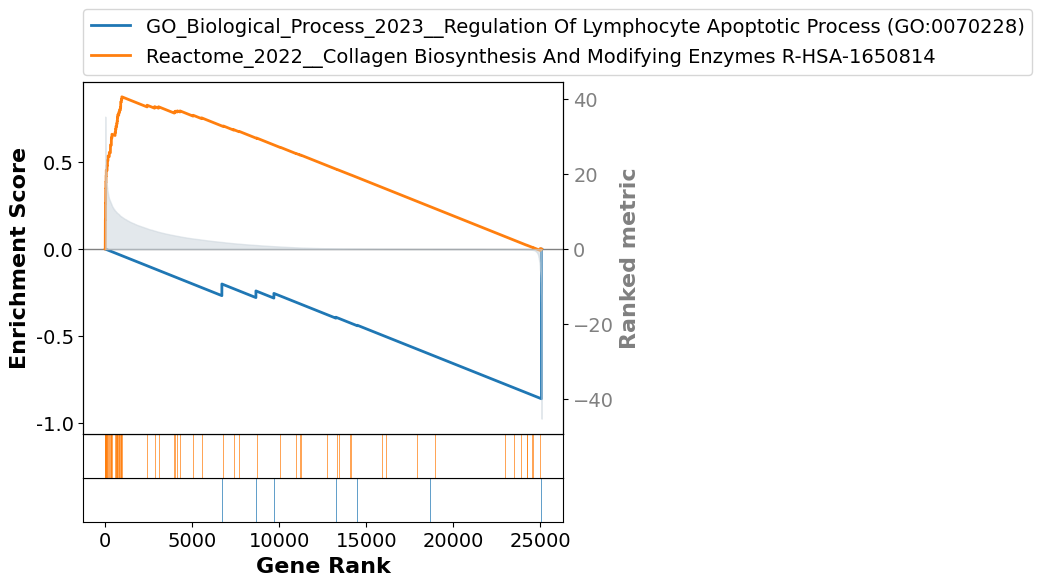

In [45]:
axs = pre_res.plot(terms=pre_res.res2d.Term[[3,34]])

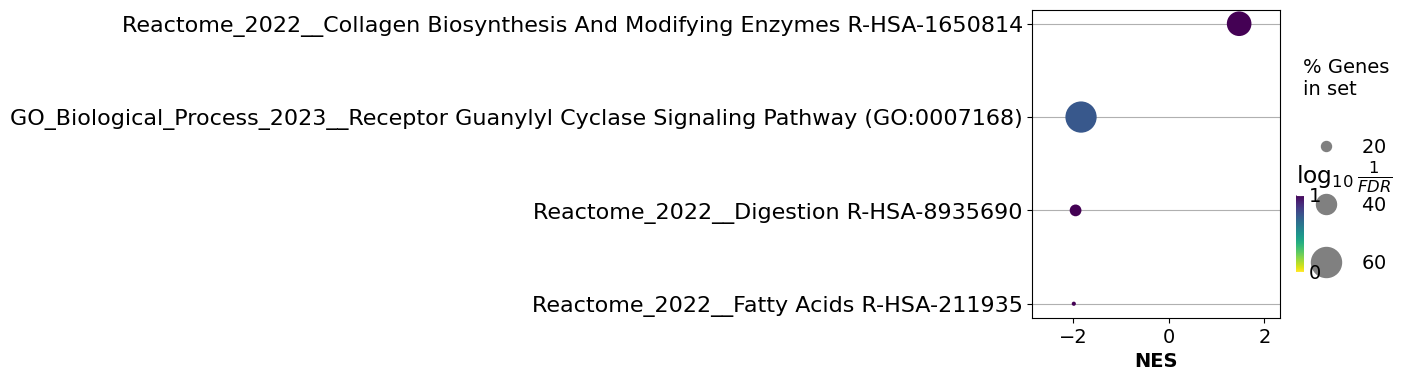

In [46]:
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             size=6, # adjust dot size
             figsize=(4,4), cutoff=0.2, show_ring=False)

In [4]:
# Boxplot of percentage of each cluster in SSc and Control samples

In [2]:
adata=anndata.read_h5ad(dir+'GSE138669_after_leiden.h5ad')

In [3]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [5, 5]

In [4]:
cluster_distribution=adata.obs[['sample_name','leiden_res_0.1']].groupby(['sample_name','leiden_res_0.1']).size()
cluster_distribution=cluster_distribution.reset_index(level=['leiden_res_0.1'])
cluster_distribution.rename({0: 'CellNumber'}, axis=1, inplace=True)
cluster_distribution=cluster_distribution.pivot_table(values="CellNumber", index='sample_name', columns="leiden_res_0.1")
cluster_distribution['Total_cell']=cluster_distribution.sum(axis=1)
for columns in cluster_distribution.columns[:-1]:
  cluster_distribution[columns]=cluster_distribution[columns]/cluster_distribution['Total_cell']
cluster_distribution.drop('Total_cell', axis=1, inplace=True)
cluster_distribution['sample_name']=cluster_distribution.index
cluster_distribution=pd.melt(cluster_distribution, id_vars='sample_name', value_vars=['0', '1', '2', '3', '4'])
cluster_distribution.index=cluster_distribution['sample_name']

In [5]:
condition=adata.obs[['sample_name','condition']].drop_duplicates()
condition.index=condition['sample_name']
condition.drop('sample_name',axis=1,inplace=True)
cluster_distribution=cluster_distribution.join(condition)

In [6]:
cluster_distribution.rename({'value':'Percentage'}, axis=1, inplace=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1_CONTROL v.s. 1_SSC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.900e+01
0_CONTROL v.s. 0_SSC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.011e-01 U_stat=3.100e+01
2_CONTROL v.s. 2_SSC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.588e-01 U_stat=9.000e+01
3_CONTROL v.s. 3_SSC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.400e+01
4_CONTROL v.s. 4_SSC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.900e+01


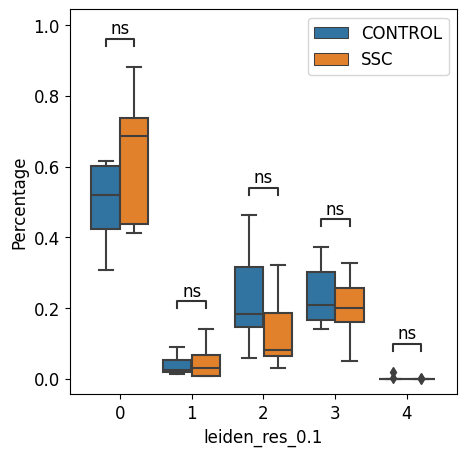

In [8]:
order=['0', '1', '2', '3', '4']
hue_order=['CONTROL', 'SSC']
box_pairs=[((cluster,hue_order[0]),(cluster,hue_order[1])) for cluster in order]
ax=sns.boxplot(data=cluster_distribution, x="leiden_res_0.1", y="Percentage", hue="condition")
add_stat_annotation(ax, data=cluster_distribution, x="leiden_res_0.1", y="Percentage", hue="condition", box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))